##### Main required libraries: ctapipe, eventio. You can install in you python enviroment using: pip install library_name

##### ex: pip install eventio

# Reading some shower info from ...simtel.zst files

In [1]:
from eventio.simtel import SimTelFile
import numpy as np

In [2]:
with SimTelFile('prod1.simtel.zst') as f:
    print('Number of telescopes:', f.n_telescopes)
    #print(f.mc_run_headers)
    print('obsheight:',f.mc_run_headers[0]['obsheight'])

Number of telescopes: 4
obsheight: 1800.0


# Reading images from .simtel.zst file

In [3]:
# code taken from ref: https://github.com/cta-observatory/pyeventio/blob/main/examples/plot_events.py
import matplotlib.pyplot as plt

import astropy.units as u
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

def build_cam_geom(simtel_file, telescope_id):
    cam_data = simtel_file.telescope_descriptions[telescope_id]['camera_settings']
    
    if cam_data['pixel_shape'][0] == 2:
        pix_type = 'square'
        pix_rotation = 0 * u.deg
    
    elif cam_data['pixel_shape'][0] == 1:
        pix_type = 'hexagonal'

        # I added this part to read your type cam which is HESS-I. It has 960 pixels
        if cam_data['n_pixels'] == 960:
            pix_rotation = 0 * u.deg
            # if you comment the next line, it will created a camera image with the pixels not rotated
            return CameraGeometry.from_name('HESS-I')
        
        # LST has 0 deg rotation, MST 30 (flat top vs. pointy top hexagons)
        if cam_data['n_pixels'] == 1855:
            pix_rotation = 0 * u.deg
        else:
            pix_rotation = 30 * u.deg

    # if pix_type == -1, we have to guess
    elif cam_data['pixel_shape'][0] == -1:
        if cam_data['n_pixels'] > 2000:
            pix_type = 'square'
            pix_rotation = 0 * u.deg
        else:
            pix_type = 'hexagonal'

            # LST has 0 deg rotation, MST 30 (flat top vs. pointy top hexagons)
            if cam_data['n_pixels'] == 1855:
                pix_rotation = 0 * u.deg
            else:
                pix_rotation = 30 * u.deg

    return CameraGeometry(
        #cam_id='CAM-{}'.format(telescope_id), ## commented
        name='CAM-{}'.format(telescope_id), # added
        pix_id=np.arange(cam_data['n_pixels']),
        pix_x=cam_data['pixel_x'] * u.m,
        pix_y=cam_data['pixel_y'] * u.m,
        pix_area=cam_data['pixel_area'] * u.m**2,
        pix_type=pix_type,
        cam_rotation=cam_data['cam_rot'] * u.rad,
        pix_rotation=pix_rotation,
    )

Event_id: 100
Telescope_id: 1


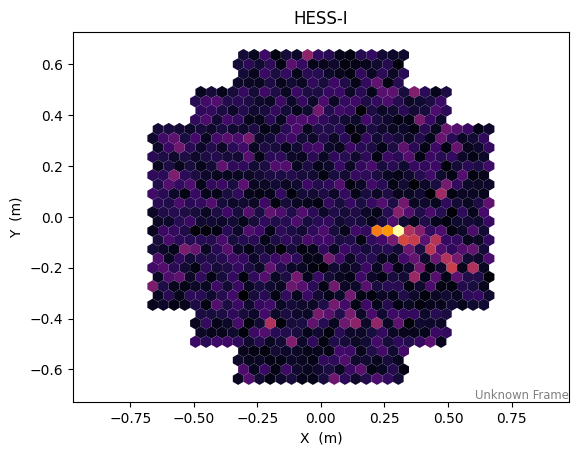

Telescope_id: 4


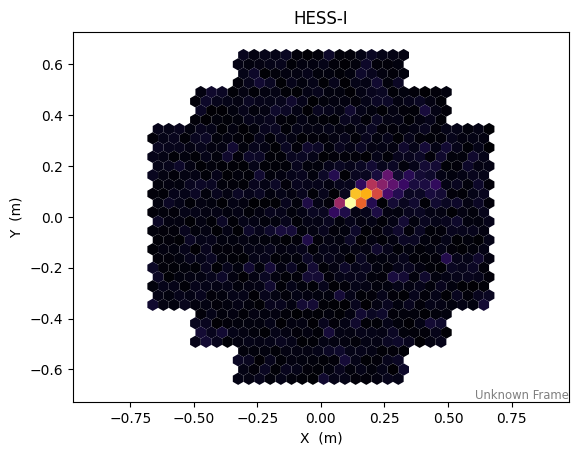

Event_id: 103
Telescope_id: 1


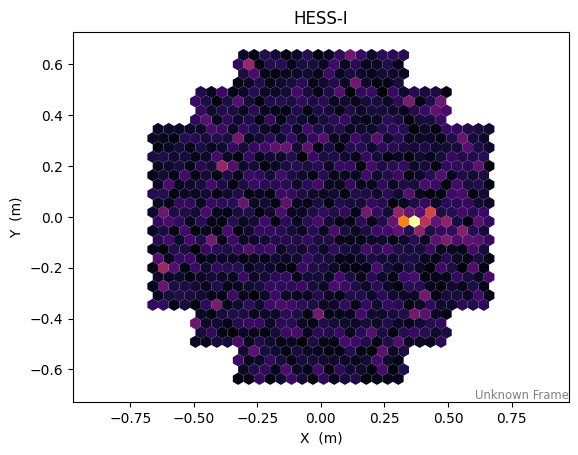

Telescope_id: 4


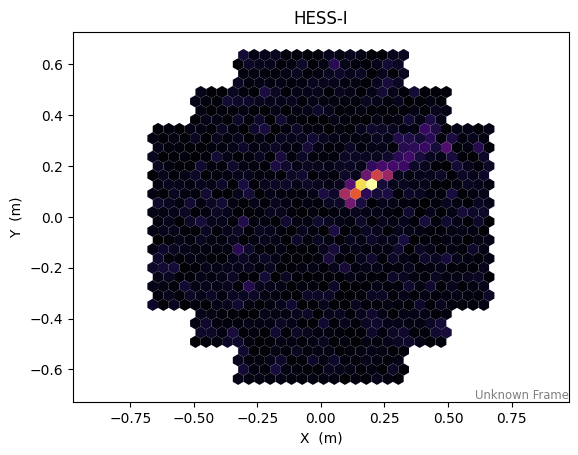

Event_id: 104
Telescope_id: 2


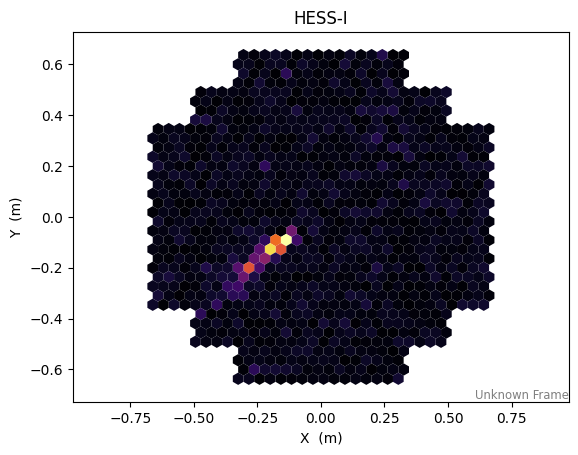

Telescope_id: 3


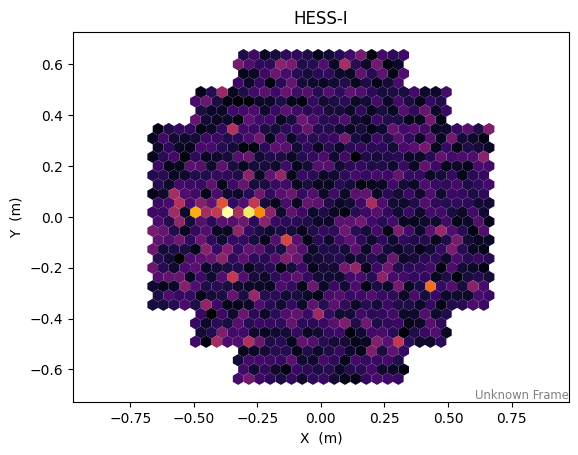

Event_id: 105
Telescope_id: 1


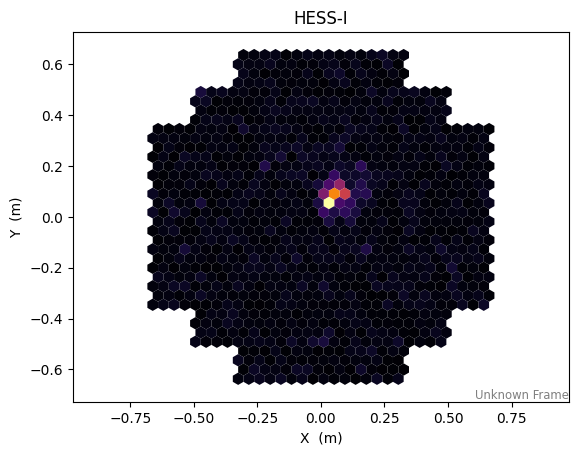

Telescope_id: 2


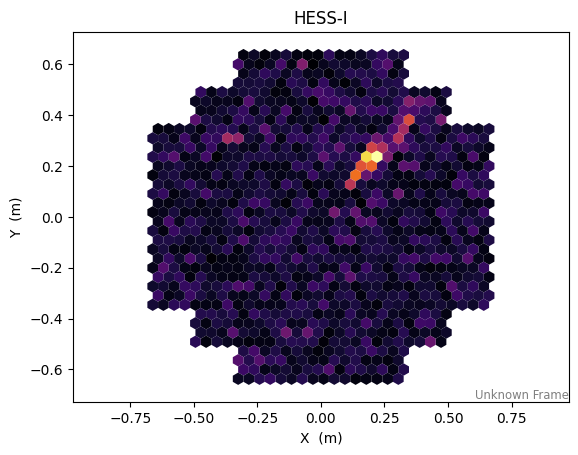

Telescope_id: 4


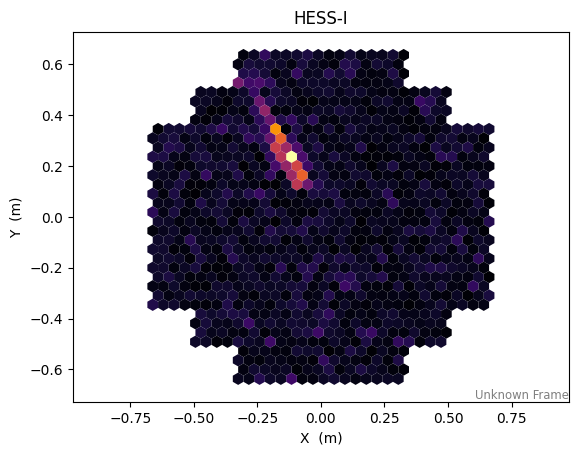

In [11]:
with SimTelFile('prod1.simtel.zst') as f:
    
    for array_event in f:
        #print(array_event)
        print('Event_id:', array_event['event_id'])
        #print('Keys of telescope_events object', array_event['telescope_events'].keys())
        for telescope_id, event in array_event['telescope_events'].items():
            print('Telescope_id:', telescope_id)
            #print('Keys of telescope_events object:', event.keys())
            
            data = event.get('adc_samples')
            if data is None:
                data = event['adc_sums'][:, :, np.newaxis]

            image = data[0].sum(axis=1)

            #print(np.shape(image))

            cam = build_cam_geom(f, telescope_id)

            ### uncomment these lines to get an square image
            #image_square = cam.image_to_cartesian_representation(image)
            #plt.imshow(image_square)
            
            plt.figure()
            disp = CameraDisplay(cam)
            disp.image = image
            plt.show()

        # comment this part to read all your events
        # I only added this for not ploting all the events
        # which it'll take a long time
        if array_event['event_id'] > 104:
            break

# Using data-handler for extracted and converting hexagonal images into square images

In [5]:
from dl1_data_handler.image_mapper import ImageMapper
# See this for ref: https://github.com/cta-observatory/dl1-data-handler/blob/master/notebooks/test_image_mapper.ipynb

In [6]:
# Define the camera types and mapping methods
# Just for reference and have an idea of all posibilities
hex_cams       = ['LSTCam', 'FlashCam', 'NectarCam', 'DigiCam', 'VERITAS','MAGICCam', 'FACT', 'HESS-I', 'HESS-II']
square_cams    = ['SCTCam', 'CHEC', 'ASTRICam']
camera_types   = hex_cams + square_cams
hex_methods    = ['oversampling', 'rebinning', 'nearest_interpolation', 'bilinear_interpolation', 'bicubic_interpolation', 'image_shifting', 'axial_addressing']
square_methods = ['oversampling', 'rebinning', 'nearest_interpolation', 'bilinear_interpolation', 'bicubic_interpolation']

In [7]:
# you need to define a dictionary with your type of camera and mapping method according to pixel type
mapping_method = {'HESS-I': 'oversampling'} #you can use any hex methods instead 

In [8]:
# here you create the mapper object to get a processed image with padding (the corners are set to zero intensity)
IM = ImageMapper(camera_types=['HESS-I'], mapping_method=mapping_method)

Event_id: 100
Telescope_id: 1


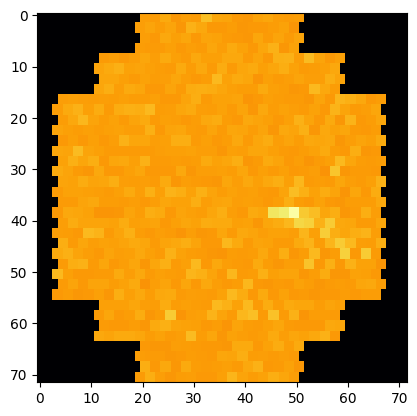

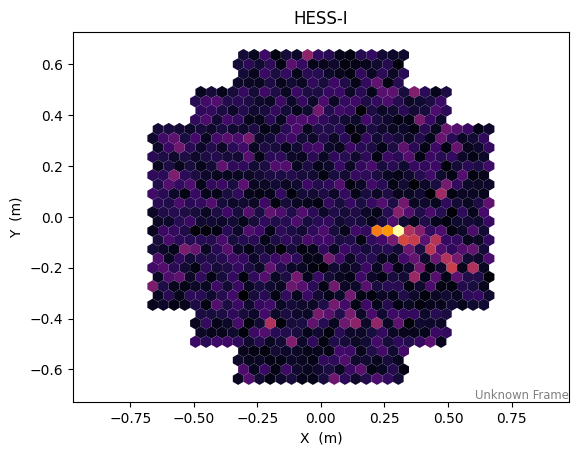

Telescope_id: 4


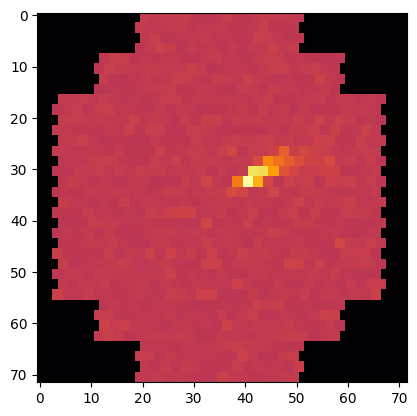

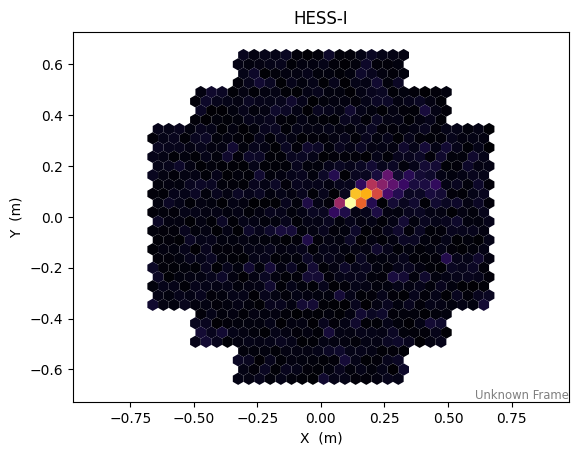

Event_id: 103
Telescope_id: 1


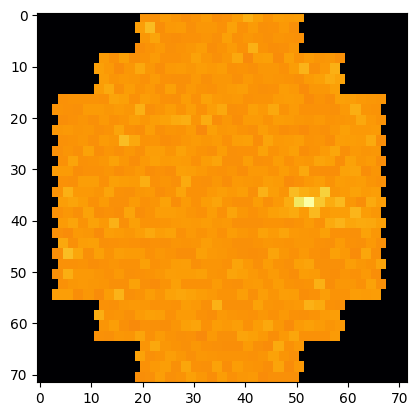

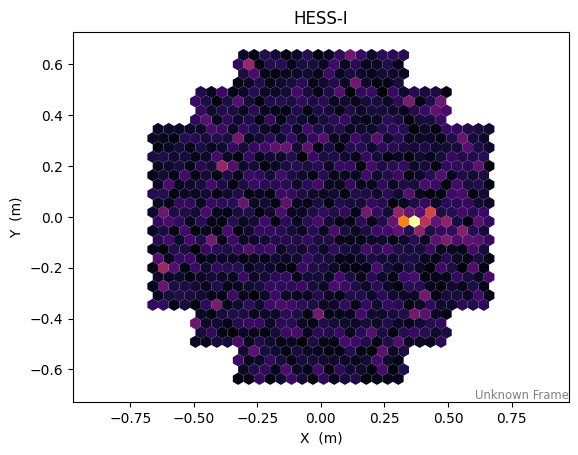

Telescope_id: 4


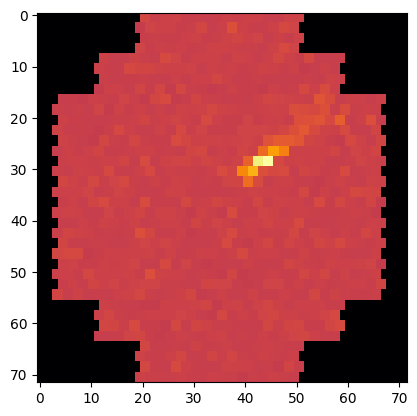

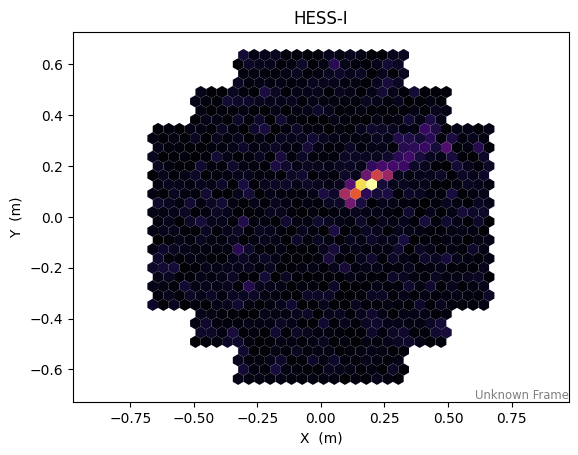

Event_id: 104
Telescope_id: 2


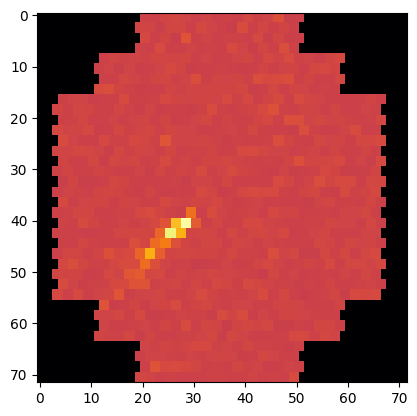

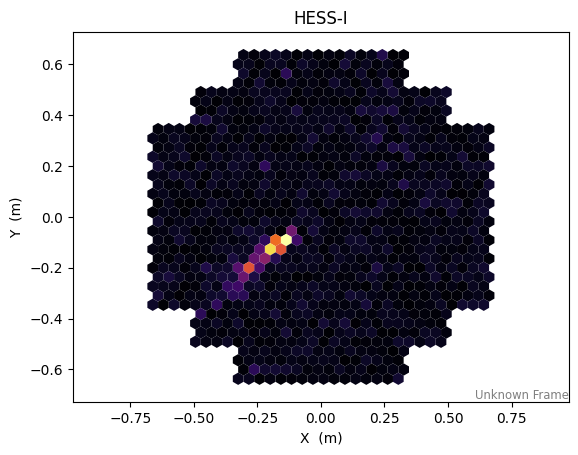

Telescope_id: 3


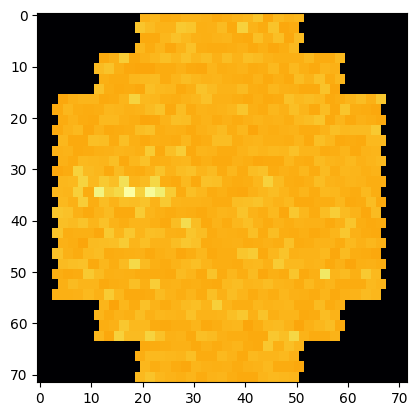

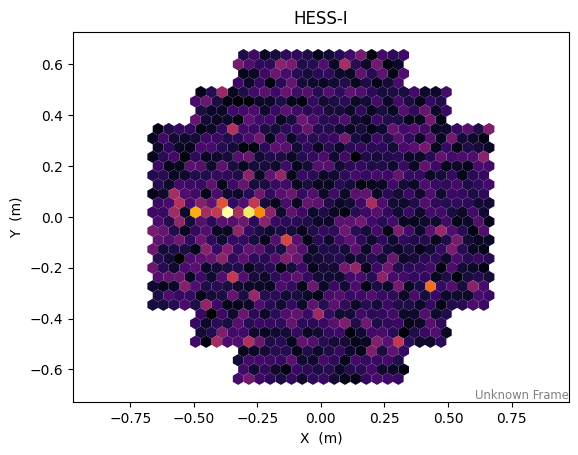

Event_id: 105
Telescope_id: 1


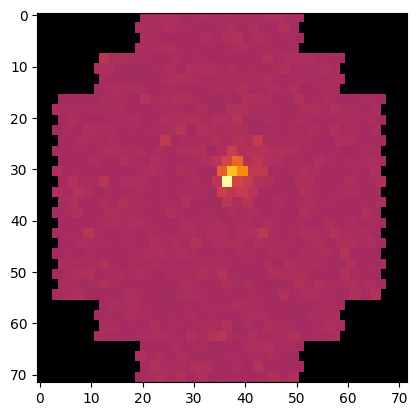

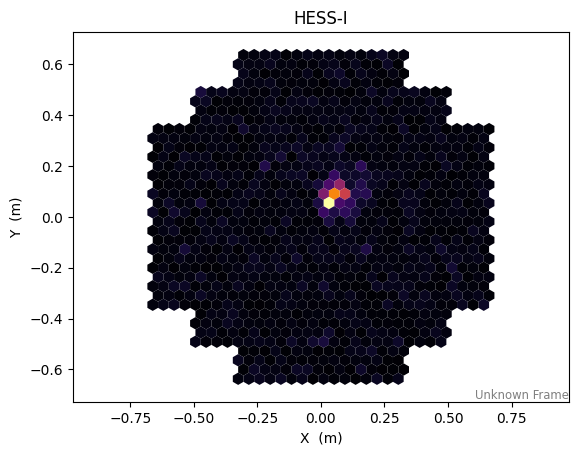

Telescope_id: 2


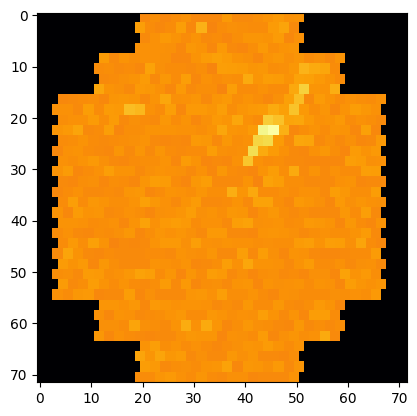

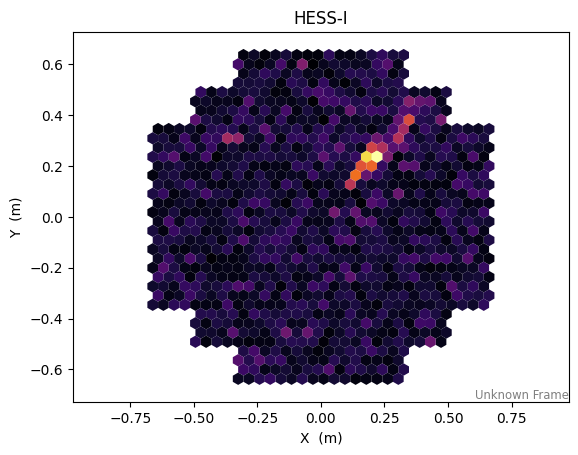

Telescope_id: 4


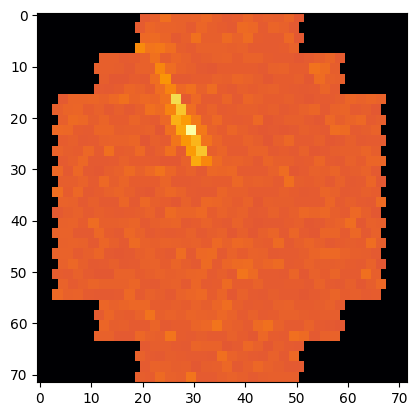

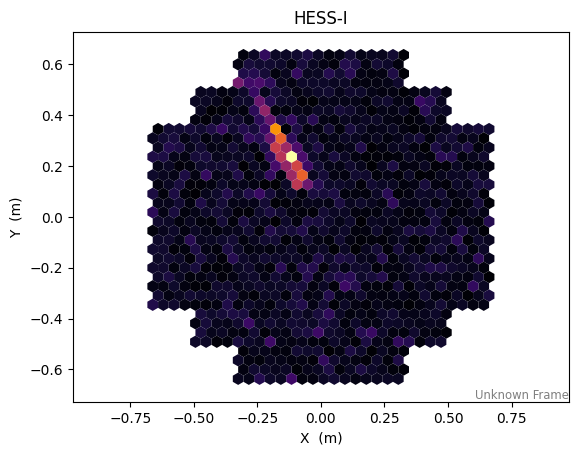

Event_id: 200
Telescope_id: 1


KeyboardInterrupt: 

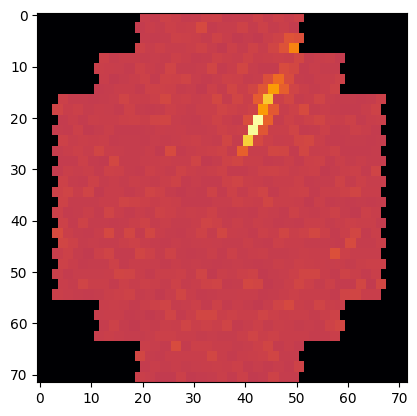

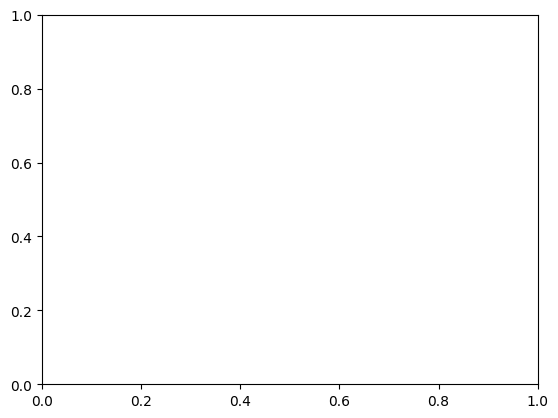

In [9]:
with SimTelFile('prod1.simtel.zst') as f:
    
    for array_event in f:
        #print(array_event)
        print('Event_id:', array_event['event_id'])
        #print('Keys of telescope_events object', array_event['telescope_events'].keys())
        for telescope_id, event in array_event['telescope_events'].items():
            print('Telescope_id:', telescope_id)
            #print('Keys of telescope_events object:', event.keys())
            
            data = event.get('adc_samples')
            if data is None:
                data = event['adc_sums'][:, :, np.newaxis]

            image = data[0].sum(axis=1)

            ############# image processing for Machine Learning ####
            ########################################################
            
            new_image = image[:,np.newaxis]
            #print(np.shape(new_image))
            
            new_image = IM.map_image(new_image, 'HESS-I')
            plt.imshow(new_image, cmap='inferno')#'viridis'
            ########################################################
            
            cam = build_cam_geom(f, telescope_id)
            
            plt.figure()
            disp = CameraDisplay(cam)
            disp.image = image
            plt.show()
            
            